In [551]:
import os
import json
from collections import defaultdict, Counter
from itertools import product, combinations
import numpy as np
import argparse
import cvxpy as cp
import scipy.sparse as sparse
import random
import gzip
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from os import listdir
import statsmodels.api as sm

In [476]:
dataset = '../recomb_ssc.hg38'
data_dirs = [#'../../DATA/ssc.hg38/genotypes/phase1-1',
             #'../../DATA/ssc.hg38/genotypes/phase1-2',
             #'../../DATA/ssc.hg38/genotypes/phase1-3',
             #'../../DATA/ssc.hg38/genotypes/phase1-4',
             '../../DATA/ssc.hg38/genotypes/phase1-5',
             #'../../DATA/ssc.hg38/genotypes/phase1-7',
             #'../../DATA/ssc.hg38/genotypes/phase2',
             #'../../DATA/ssc.hg38/genotypes/phase2_B01',
             #'../../DATA/ssc.hg38/genotypes/phase2_Replacements',
             #'../../DATA/ssc.hg38/genotypes/phase3_1',
             #'../../DATA/ssc.hg38/genotypes/phase3_1_B02',
             #'../../DATA/ssc.hg38/genotypes/phase3_2',
             #'../../DATA/ssc.hg38/genotypes/phase4',
             #'../../DATA/ssc.hg38/genotypes/pilot',
            ]
chroms = [str(x) for x in range(1, 23)]
#chroms = ['10']

In [477]:
def check_crossovers(crossovers):
	for co in crossovers:
		if co['start_pos'] == co['end_pos']:
			print(co)
		assert co['start_pos'] != co['end_pos']

	# remove quads/crossovers involving the same child
	quads = set()
	children = set()
	ok_crossovers = []
	for co in crossovers:
		if tuple(co['child']) in quads:
			ok_crossovers.append(co)
		elif co['child'][0] in children or co['child'][1] in children:
			pass
		else:
			quads.add(tuple(co['child']))
			children.add(co['child'][0])
			children.add(co['child'][1])
			ok_crossovers.append(co)

	print('children with phase information', 2*len(quads))
	print('removed crossovers from siblings in multiple sibpairs', len(crossovers)-len(ok_crossovers))
	return ok_crossovers, sorted(quads)

# pull crossover information
with open('%s/crossovers.json' % dataset, 'r') as f:
	crossovers, quads = check_crossovers(json.load(f))
    
# pull gene conversions information
with open('%s/gene_conversions.json' % dataset, 'r') as f:
	gene_conversions, _ = check_crossovers(json.load(f))

children with phase information 3810
removed crossovers from siblings in multiple sibpairs 0
children with phase information 3810
removed crossovers from siblings in multiple sibpairs 0


In [478]:
print(len(crossovers), len(gene_conversions))

270750 406636


In [479]:
moms, dads = set(), set()
parent_to_crossovers = defaultdict(list)
parent_to_gcs = defaultdict(list)


for co in crossovers:
    if co['is_mat'] and co['chrom'] in chroms:
        moms.add(co['mom'])
        parent_to_crossovers[co['mom']].append(co)

    elif co['is_pat'] and co['chrom'] in chroms:
        dads.add(co['dad'])
        parent_to_crossovers[co['dad']].append(co)
                                                 
        
for gc in gene_conversions:
    if gc['is_mat'] and gc['chrom'] in chroms:
        moms.add(gc['mom'])
        parent_to_gcs[gc['mom']].append(gc)
    elif gc['is_pat'] and gc['chrom'] in chroms:
        dads.add(gc['dad'])
        parent_to_gcs[gc['dad']].append(gc)
        
moms = sorted(moms)
dads = sorted(dads)
print('moms', len(moms), 'dads', len(dads), len(parent_to_crossovers), len(parent_to_gcs),
     len(parent_to_gc_recombs), len(parent_to_co_recombs))






moms 1905 dads 1905 3810 3810 156 156


In [390]:
## sequence
#chrom_to_seq = defaultdict(list)
#for chrom in chroms:
#    with open('../data/chroms38/chr%s.fa' % chrom, 'r') as f:
#        next(f) # skip header
#        for line in f:
#            chrom_to_seq[chrom].append(line.strip())
#    
#def get_sequence(chrom, start_pos, end_pos):
#    start_line_num = int(math.floor((start_pos-1)/50))
#    end_line_num = int(math.floor((end_pos-1)/50))
#    start_offset = (start_pos-1) - 50*start_line_num
#    end_offset = (end_pos-1) - 50*end_line_num
#    #print(start_line_num, end_line_num, start_offset, end_offset)
#    
#    if start_line_num == end_line_num:
#        return chrom_to_seq[chrom][start_line_num][start_offset:end_offset]
#    else:
#        return ''.join([chrom_to_seq[chrom][start_line_num][start_offset:]] + chrom_to_seq[chrom][start_line_num+1:end_line_num] + [chrom_to_seq[chrom][end_line_num][:end_offset]])
#    
#print(get_sequence(348734-10, 348734+10))


In [391]:
bp = {'A': 'T', 'a':'t', 'C':'G', 'c':'g', 'G':'C', 'g':'c', 'T':'A', 't':'a'}
def reverse_complement(s):
    return ''.join([bp[x] for x in s[::-1]])

In [645]:
parent_chrom_to_gen = dict()
parent_to_data_dir = dict()
data_dir_chrom_to_refalts = dict()


for data_dir in data_dirs:
    print(data_dir)
    for chrom in chroms:
        print(chrom, end=' ')
        # ref/alts
        pos, refs, alts = [], [], []
        gen_files = sorted([f[:-4] for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
        print(gen_files)
        for gen_file in gen_files:
            with gzip.open('%s/%s.variants.txt.gz' % (data_dir, gen_file), 'rt') as f:
                for line in f:
                    pieces = line.strip().split('\t', maxsplit=5)
                    refs.append(pieces[3])
                    alts.append(pieces[4])
                    pos.append(int(pieces[1]))
        pos = np.array(pos)
        data_dir_chrom_to_refalts[(data_dir, chrom)] = (pos, refs, alts)

        # gens
        with open('%s/samples.json' % data_dir, 'r') as f:
            samples = json.load(f)
        #parents = [mom for mom in mom_to_crossovers.keys() if mom in samples] + [dad for dad in dad_to_crossovers.keys() if dad in samples]
        #indices = [samples.index(parent) for parent in parents]

        gen = np.hstack(([sparse.load_npz('%s/%s.npz' % (data_dir, gen_file)).A for gen_file in gen_files]))
        for i, sample in enumerate(samples):
            parent_chrom_to_gen[(sample, chrom)] = gen[i, :]
            parent_to_data_dir[sample] = data_dir
    

../../DATA/ssc.hg38/genotypes/phase1-5
1 ['chr.1.0.gen', 'chr.1.1.gen', 'chr.1.2.gen', 'chr.1.3.gen', 'chr.1.4.gen', 'chr.1.5.gen', 'chr.1.6.gen', 'chr.1.7.gen', 'chr.1.8.gen', 'chr.1.9.gen', 'chr.1.10.gen', 'chr.1.11.gen', 'chr.1.12.gen', 'chr.1.13.gen', 'chr.1.14.gen', 'chr.1.15.gen', 'chr.1.16.gen', 'chr.1.17.gen', 'chr.1.18.gen', 'chr.1.19.gen', 'chr.1.20.gen', 'chr.1.21.gen', 'chr.1.22.gen', 'chr.1.23.gen', 'chr.1.24.gen']
2 ['chr.2.0.gen', 'chr.2.1.gen', 'chr.2.2.gen', 'chr.2.3.gen', 'chr.2.4.gen', 'chr.2.5.gen', 'chr.2.6.gen', 'chr.2.7.gen', 'chr.2.8.gen', 'chr.2.9.gen', 'chr.2.10.gen', 'chr.2.11.gen', 'chr.2.12.gen', 'chr.2.13.gen', 'chr.2.14.gen', 'chr.2.15.gen', 'chr.2.16.gen', 'chr.2.17.gen', 'chr.2.18.gen', 'chr.2.19.gen', 'chr.2.20.gen', 'chr.2.21.gen', 'chr.2.22.gen', 'chr.2.23.gen', 'chr.2.24.gen']
3 ['chr.3.0.gen', 'chr.3.1.gen', 'chr.3.2.gen', 'chr.3.3.gen', 'chr.3.4.gen', 'chr.3.5.gen', 'chr.3.6.gen', 'chr.3.7.gen', 'chr.3.8.gen', 'chr.3.9.gen', 'chr.3.10.gen', 'chr.3

In [685]:
print(len(parent_to_crossovers), len(parent_to_gcs))
parent_to_crossovers = dict([(parent, cos) for parent, cos in parent_to_crossovers.items() if parent in parent_to_data_dir])
parent_to_gcs = dict([(parent, gcs) for parent, gcs in parent_to_gcs.items() if parent in parent_to_data_dir])
print(len(parent_to_crossovers), len(parent_to_gcs))


156 156
156 156


In [686]:
print(len(parent_to_crossovers['SSC06630']))
print(len(parent_to_gcs['SSC06630']))

57
52


In [648]:
data_dir_chrom_to_snps = dict()
bp_to_int = {
    'A': 0,
    'C': 1,
    'G': 2,
    'T': 3
}
for data_dir_chrom, (pos, refs, alts) in data_dir_chrom_to_refalts.items():
    is_snp = np.array([len(r)==1 for r in refs]) & np.array([len(a)==1 for a in alts])
    data_dir_chrom_to_snps[data_dir_chrom] = is_snp
    data_dir_chrom_to_refalts[data_dir_chrom] = (np.array([bp_to_int[refs[i]] for i in np.where(is_snp)[0]]),
                                                 np.array([bp_to_int[alts[i]] for i in np.where(is_snp)[0]]),
                                                 pos[is_snp])

In [763]:
of_interest = [('AT',), ('CG',), ('AG',), ('CT',), ('AC',), ('GT',), ('AG', 'CT'), ('AC', 'GT'), ('AC', 'AG', 'AT', 'CG', 'CT', 'GT')]

bp = ['A', 'C', 'G', 'T']

def pull_het_sites(parent, cos, chrom, key):
    refs, alts, pos = data_dir_chrom_to_refalts[(parent_to_data_dir[parent], chrom)]   
    is_snp = data_dir_chrom_to_snps[(parent_to_data_dir[parent], chrom)]
    gen = parent_chrom_to_gen[(parent, chrom)][is_snp]
    
    assert len(gen) == len(pos)
    
    is_het = (gen==1)
        
    pos = pos[is_het]
    refs = refs[is_het]
    alts = alts[is_het]
                
    # crossovers
    rs_of_interest = sum([co['recombinations'] for co in cos if co['chrom']==chrom and co['start_pos']>=pos[0] and co['end_pos']<=pos[-1]], [])
    
    start_pos = np.array([r['start_pos'] for r in rs_of_interest])
    start_indices = np.searchsorted(pos, start_pos+1)-1

    end_pos = np.array([r['end_pos'] for r in rs_of_interest])
    end_indices = np.searchsorted(pos, end_pos)
    
    #print('start', start_pos, start_indices)
    #print(pos[start_indices])
    #print(pos[start_indices+1])
    
    assert np.all(pos[start_indices] <= start_pos)
    assert np.all(start_pos <= pos[start_indices+1])
    assert np.all(pos[end_indices-1] <= end_pos)
    assert np.all(end_pos <= pos[end_indices])
    assert np.all(end_indices-start_indices+1 >= 2)
    
    #assert np.all(gen[start_indices]==1)
    #assert np.all(gen[end_indices]==1)
    assert len(start_indices)==len(end_indices)

    for r, start_index, end_index in zip(rs_of_interest, start_indices, end_indices):
        if end_index-(start_index+1) >= 2:
            pairs = [min(bp[refs[k]], bp[alts[k]])+max(bp[refs[k]], bp[alts[k]]) for k in range(start_index+1, end_index)]            
        elif end_index-start_index >= 2:
            pairs = [min(bp[refs[k]], bp[alts[k]])+max(bp[refs[k]], bp[alts[k]]) for k in range(start_index, end_index)]            
        else:
            pairs = [min(bp[refs[k]], bp[alts[k]])+max(bp[refs[k]], bp[alts[k]]) for k in range(start_index, end_index+1)]
        r[key] = dict()
        r[key]['pairs'] = pairs
        r[key]['pair_positions'] = [pos[k] for k in range(start_index, end_index+1)]
        #r[key]['pair_indices'] = indices
        
        for p in of_interest:
            r[key][p] = len([x for x in pairs if x in p])

for parent, parent_crossovers in parent_to_crossovers.items():
    print(parent, end=' ')
    parent_gcs = parent_to_gcs[parent]
    #parent_co_recombs = parent_to_co_recombs[parent]
    #parent_gc_recombs = parent_to_gc_recombs[parent]
    
    another_parent = parent
    while another_parent == parent:
        if parent in moms:
            another_parent, another_crossovers = random.choice([(k, v) for k, v in parent_to_crossovers.items() if k in moms])
        elif parent in dads:
            another_parent, another_crossovers = random.choice([(k, v) for k, v in parent_to_crossovers.items() if k in dads])
        else:
            print('neither mom nor dad', parent)
            
    
    for chrom_index, chrom in enumerate(chroms):
        print(chrom, end=' ')
        pull_het_sites(parent, parent_crossovers, chrom, 'hets')
        pull_het_sites(parent, parent_gcs, chrom, 'hets')
        pull_het_sites(another_parent, parent_crossovers, chrom, 'another_hets')
        pull_het_sites(another_parent, parent_gcs, chrom, 'another_hets')
        
        #pull_het_sites(parent, parent_co_recombs, chrom, 'rs')
        #pull_het_sites(parent, parent_gc_recombs, chrom, 'rs')
        #pull_het_sites(another_parent, parent_co_recombs, chrom, 'another_rs')
        #pull_het_sites(another_parent, parent_gc_recombs, chrom, 'another_rs')

        
    print()


SSC01964 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC01965 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC03720 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC03730 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC02689 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC02704 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC00765 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC00766 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC00255 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC00256 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC03656 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC03664 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC03794 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC03800 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
SSC05609 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21

In [764]:
start_ends = np.zeros((7,), dtype=int)
for parent, cos in parent_to_crossovers.items():
    for co in cos:
        gen = parent_chrom_to_gen[(parent, co['chrom'])]
        pos, refs, alts = data_dir_chrom_to_refalts[(parent_to_data_dir[parent], co['chrom'])]  
        for r in co['recombinations']:
            #assert np.all(pos[r['hets']['pair_indices']]==np.array(r['hets']['pair_positions']))
            #assert np.all(gen[r['hets']['pair_indices']]==1)
            to_add = np.zeros((7,), dtype=int)
            
            to_add[0] = len([x for x in r['hets']['pair_positions'] if x<r['start_pos']])
            if r['start_pos'] in r['hets']['pair_positions']:
                to_add[1] = 1
            to_add[2] = len([x for x in r['hets']['pair_positions'] if x-r['start_pos']<1000])
            to_add[4] = len([x for x in r['hets']['pair_positions'] if r['end_pos']-x<1000])
            if r['end_pos'] in r['hets']['pair_positions']:
                to_add[5] = 1
            to_add[6] = len([x for x in r['hets']['pair_positions'] if r['end_pos']<x])

            to_add[3] = len(r['hets']['pair_positions'])-np.sum(to_add)
            
            start_ends += to_add


[    689   10582   16252 1501272   16644   10592     679]


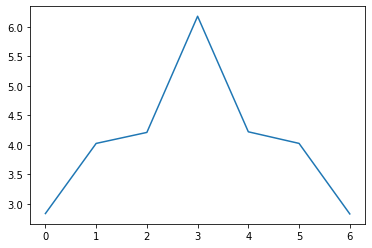

In [765]:
print(start_ends)
plt.plot(np.log10(start_ends))
plt.show()

[True]
[True]
0 0
152353514 [152353514]
152354849 [152354849]


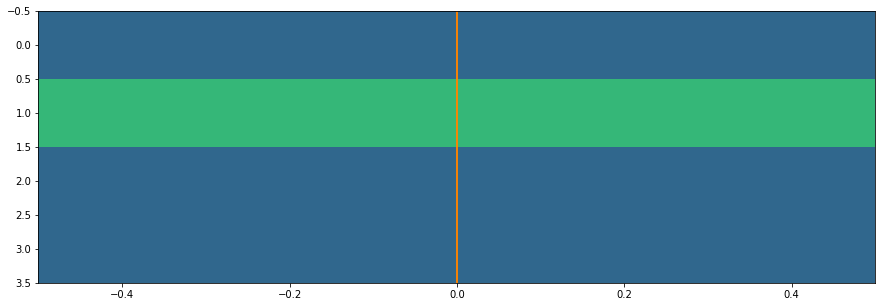

In [714]:
co = cos[2]
print([r['is_left_match'] for r in co['recombinations']])
print([r['is_other_parent_match'] for r in co['recombinations']])

start_index = None
end_index = None
for r in co['recombinations']:
    assert r['is_left_match'] != r['is_right_match']
            
    for p, i in zip(r['hets']['pair_positions'], r['hets']['pair_indices']):
        if co['start_pos'] == p:
            start_index = i
        if co['end_pos'] == p:
            end_index = i
       
     
if start_index is not None and end_index is not None:
    child1_gen_start = parent_chrom_to_gen[(co['child'][0], co['chrom'])][start_index]
    child2_gen_start = parent_chrom_to_gen[(co['child'][1], co['chrom'])][start_index]
    child1_gen_end = parent_chrom_to_gen[(co['child'][0], co['chrom'])][end_index]
    child2_gen_end = parent_chrom_to_gen[(co['child'][1], co['chrom'])][end_index]
    print(child1_gen_start==child2_gen_start, child1_gen_end==child2_gen_end)
            
pos, refs, alts = data_dir_chrom_to_refalts[(parent_to_data_dir[parent], co['chrom'])]  
gen = parent_chrom_to_gen[(parent, co['chrom'])]
spouse_gen = parent_chrom_to_gen[(co['dad'] if co['is_mat'] else co['mom'], co['chrom'])]
child1_gen = parent_chrom_to_gen[(co['child'][0], co['chrom'])]
child2_gen = parent_chrom_to_gen[(co['child'][1], co['chrom'])]

start_index, end_index = np.searchsorted(pos, [co['start_pos'], co['end_pos']])
print(gen[start_index], gen[end_index])
print(co['start_pos'], [r['start_pos'] for r in co['recombinations']])
print(co['end_pos'], [r['end_pos'] for r in co['recombinations']])
start_indices = np.searchsorted(pos, [r['start_pos'] for r in co['recombinations']])
end_indices = np.searchsorted(pos, [r['end_pos'] for r in co['recombinations']])

plt.figure(figsize=(15, 5))
plt.imshow(np.array([gen, spouse_gen, child1_gen, child2_gen])[:, start_index:end_index+1], aspect='auto', vmin=-1, vmax=2)
for s, e in zip(start_indices, end_indices):
    plt.axvline(s-start_index, color='red')
    plt.axvline(e-start_index, color='orange')
#plt.colorbar()
plt.show()

In [715]:
print(list(product([0, 1], repeat=4)))
print(list(product(*[[0, 1], [2, 3], [0, 1], [2, 3]])))

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1)]
[(0, 2, 0, 2), (0, 2, 0, 3), (0, 2, 1, 2), (0, 2, 1, 3), (0, 3, 0, 2), (0, 3, 0, 3), (0, 3, 1, 2), (0, 3, 1, 3), (1, 2, 0, 2), (1, 2, 0, 3), (1, 2, 1, 2), (1, 2, 1, 3), (1, 3, 0, 2), (1, 3, 0, 3), (1, 3, 1, 2), (1, 3, 1, 3)]


In [716]:
match_to_mismatch_match_match, match_to_mismatch_match_mismatch = 0, 0
match_to_mismatch_mismatch_match, match_to_mismatch_mismatch_mismatch = 0, 0

mismatch_to_match_match_match, mismatch_to_match_match_mismatch = 0, 0
mismatch_to_match_mismatch_match, mismatch_to_match_mismatch_mismatch = 0, 0

left_hets = defaultdict(int)
right_hets = defaultdict(int)
all_hets = defaultdict(int)

gen_to_match = defaultdict(lambda : [False, False, set()])
parent_options = list(product([0, 1], repeat=4))
inheritance_options = list(product(*[[0, 1], [2, 3], [0, 1], [2, 3]]))
for par in parent_options:
    for inh in inheritance_options:
        gen = (par[0]+par[1], par[2]+par[3], par[inh[0]]+par[inh[1]], par[inh[2]]+par[inh[3]])
        gen_to_match[(gen, inh[1]==inh[3])][inh[0]==inh[2]] = True
        if inh[0]==inh[2]:
            gen_to_match[(gen, inh[1]==inh[3])][2].add(par[inh[0]])

print(gen_to_match)


for parent, cos in parent_to_gcs.items():
    for co in cos:
        start_r = None
        end_r = None
        
        if len(co['recombinations'][0]['hets']['pair_positions'])>0 and \
           len(co['recombinations'][-1]['hets']['pair_positions'])>0 and \
           co['recombinations'][0]['hets']['pair_positions'][0]==co['start_pos'] and \
           co['recombinations'][-1]['hets']['pair_positions'][-1]==co['end_pos']:
            start_r = co['recombinations'][0]
            end_r = co['recombinations'][-1]
            
            start_index = start_r['hets']['pair_indices'][0]
            end_index = end_r['hets']['pair_indices'][-1]
        
            gen_start = parent_chrom_to_gen[(parent, co['chrom'])][start_index]
            spouse_start = parent_chrom_to_gen[(co['mom'] if co['is_pat'] else co['dad'], co['chrom'])][start_index]
            child1_gen_start = parent_chrom_to_gen[(co['child'][0], co['chrom'])][start_index]
            child2_gen_start = parent_chrom_to_gen[(co['child'][1], co['chrom'])][start_index]
            
            gen_end = parent_chrom_to_gen[(parent, co['chrom'])][end_index]
            spouse_end = parent_chrom_to_gen[(co['mom'] if co['is_pat'] else co['dad'], co['chrom'])][end_index]
            child1_gen_end = parent_chrom_to_gen[(co['child'][0], co['chrom'])][end_index]
            child2_gen_end = parent_chrom_to_gen[(co['child'][1], co['chrom'])][end_index]

            pos, refs, alts = data_dir_chrom_to_refalts[(parent_to_data_dir[parent], co['chrom'])] 
            ref_start, alt_start = refs[start_index], alts[start_index]
            ref_end, alt_end = refs[end_index], alts[end_index]

            is_mismatch_start, is_match_start, is_match_options_start = gen_to_match[(gen_start, spouse_start, child1_gen_start, child2_gen_start), start_r['is_other_parent_match']]
            is_mismatch_end, is_match_end, is_match_options_end = gen_to_match[(gen_end, spouse_end, child1_gen_end, child2_gen_end), end_r['is_other_parent_match']]
                
            if is_match_start != is_mismatch_start and is_match_end != is_mismatch_end:
                if start_r['is_left_match']:
                    if is_match_start and is_match_end:
                        match_to_mismatch_match_match += 1
                        # we're in a situation where the GC is match-mismatch-match
                        hets = []
                        if len(is_match_options_start) == 1:
                            if list(is_match_options_start)[0]==0:
                                left_hets[ref_start + alt_start] += 1
                                hets.append(ref_start)
                                hets.append(alt_start)
                            else:
                                left_hets[alt_start + ref_start ] += 1
                                hets.append(alt_start)
                                hets.append(ref_start)
                                
                        if len(is_match_options_end) == 1:
                            if list(is_match_options_end)[0]==0:
                                right_hets[ref_end + alt_end] += 1
                                hets.append(ref_end)
                                hets.append(alt_end)
                            else:
                                right_hets[alt_end + ref_end] += 1    
                                hets.append(alt_end)
                                hets.append(ref_end)
                        all_hets[tuple(hets)] += 1
                    elif is_match_start:
                        match_to_mismatch_match_mismatch += 1
                    elif is_match_end:
                        match_to_mismatch_mismatch_match += 1
                    else:
                        match_to_mismatch_mismatch_mismatch += 1
                elif start_r['is_right_match']:
                    if is_match_start and is_match_end:
                        mismatch_to_match_match_match += 1
                    elif is_match_start:
                        mismatch_to_match_match_mismatch += 1
                    elif is_match_end:
                        mismatch_to_match_mismatch_match += 1
                    else:
                        mismatch_to_match_mismatch_mismatch += 1
                    
                    
                
            #if start_index is not None and end_index is not None:
            #    pos, refs, alts = data_dir_chrom_to_refalts[(parent_to_data_dir[parent], co['chrom'])]  
            #    ref, alt = refs[start_index], alts[start_index]
            #    gen_start = parent_chrom_to_gen[(parent, co['chrom'])][start_index]
            #    assert gen_start==1
            #    spouse_gen_start = parent_chrom_to_gen[(co['dad'] if co['is_mat'] else co['mom'], co['chrom'])][start_index]
            #    child1_gen_start = parent_chrom_to_gen[(co['child'][0], co['chrom'])][start_index]
            #    child2_gen_start = parent_chrom_to_gen[(co['child'][1], co['chrom'])][start_index]#
            #
            #    gen_end = parent_chrom_to_gen[(parent, co['chrom'])][end_index]
            #    assert gen_end==1
            #    spouse_gen_end = parent_chrom_to_gen[(co['dad'] if co['is_mat'] else co['mom'], co['chrom'])][end_index]
            #    child1_gen_end = parent_chrom_to_gen[(co['child'][0], co['chrom'])][end_index]
            #    child2_gen_end = parent_chrom_to_gen[(co['child'][1], co['chrom'])][end_index]#
            #
            #    if child1_gen_start==child2_gen_start and child1_gen_end==child2_gen_end:
            #        child_gens_match_match += 1
            #    elif child1_gen_start==child2_gen_start:
            #        child_gens_match_mismatch += 1
            #    elif child1_gen_end==child2_gen_end:
            #        child_gens_mismatch_match += 1    
            #    else:
            #        child_gens_mismatch_mismatch += 1 
#print(child_gens_match_match, child_gens_match_mismatch, child_gens_mismatch_match, child_gens_mismatch_mismatch)
print(match_to_mismatch_match_match, match_to_mismatch_match_mismatch,
     match_to_mismatch_mismatch_match, match_to_mismatch_mismatch_mismatch)
print(mismatch_to_match_match_match, mismatch_to_match_match_mismatch,
     mismatch_to_match_mismatch_match, mismatch_to_match_mismatch_mismatch)


defaultdict(<function <lambda> at 0x1a5936a840>, {((0, 0, 0, 0), True): [True, True, {0}], ((0, 0, 0, 0), False): [True, True, {0}], ((0, 1, 0, 0), True): [True, True, {0}], ((0, 1, 0, 1), False): [True, True, {0}], ((0, 1, 1, 0), False): [True, True, {0}], ((0, 1, 1, 1), True): [True, True, {0}], ((0, 2, 1, 1), True): [True, True, {0}], ((0, 2, 1, 1), False): [True, True, {0}], ((1, 0, 0, 0), True): [False, True, {0}], ((1, 0, 0, 0), False): [False, True, {0}], ((1, 0, 0, 1), True): [True, False, set()], ((1, 0, 0, 1), False): [True, False, set()], ((1, 0, 1, 0), True): [True, False, set()], ((1, 0, 1, 0), False): [True, False, set()], ((1, 0, 1, 1), True): [False, True, {1}], ((1, 0, 1, 1), False): [False, True, {1}], ((1, 1, 0, 0), True): [False, True, {0}], ((1, 1, 0, 1), False): [False, True, {0}], ((1, 1, 0, 1), True): [True, False, set()], ((1, 1, 0, 2), False): [True, False, set()], ((1, 1, 1, 0), False): [False, True, {0}], ((1, 1, 1, 1), True): [False, True, {0, 1}], ((1, 1, 

IndexError: index 624371 is out of bounds for axis 0 with size 567977

defaultdict(<class 'int'>, {78502827: 1, 3233370: 1, 12375416: 1, 'AC': 0, 'CA': 0, 'AG': 0, 'GA': 0, 'AT': 0, 'TA': 0, 'CG': 0, 'GC': 0, 'CT': 0, 'TC': 0, 'GT': 0, 'TG': 0})


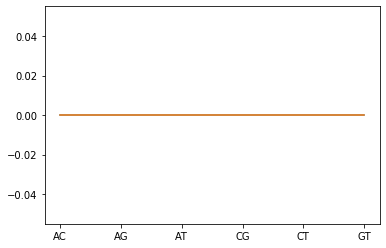

In [717]:
plt.plot([left_hets[''.join(pair)]+left_hets[''.join(reversed(pair))] for pair in combinations('ACGT', r=2)])
plt.plot([right_hets[''.join(pair)]+right_hets[''.join(reversed(pair))] for pair in combinations('ACGT', r=2)])
#plt.plot([right_hets[''.join([reverse_complement(x) for x in pair])] for pair in product('ACGT', repeat=2)])
plt.xticks(np.arange(6), [''.join(pair) for pair in combinations('ACGT', r=2)])
print(right_hets)

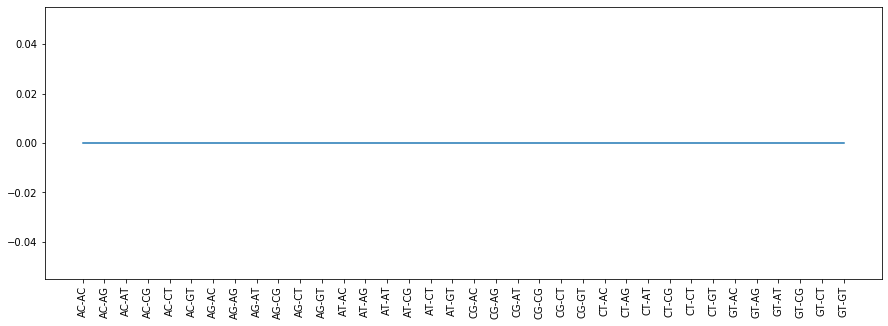

In [718]:
plt.figure(figsize=(15, 5))
plt.plot([all_hets[(quad[0][0], quad[0][1], quad[1][0], quad[1][1])] for quad in product(combinations('ACGT', r=2), repeat=2)])
plt.xticks(np.arange(36), [''.join(quad[0]) + '-' + ''.join(quad[1]) for quad in product(list(combinations('ACGT', r=2)), repeat=2)], rotation=90)
plt.show()

In [766]:
crossover_recombs = sum([sum([co['recombinations'] for co in v], []) for v in parent_to_crossovers.values()], [])
gene_conversion_recombs = sum([sum([co['recombinations'] for co in v], []) for v in parent_to_gcs.values()], [])


In [767]:
print(len(crossovers), len(gene_conversions), len(crossover_recombs), len(gene_conversion_recombs))

270750 406636 11271 34210


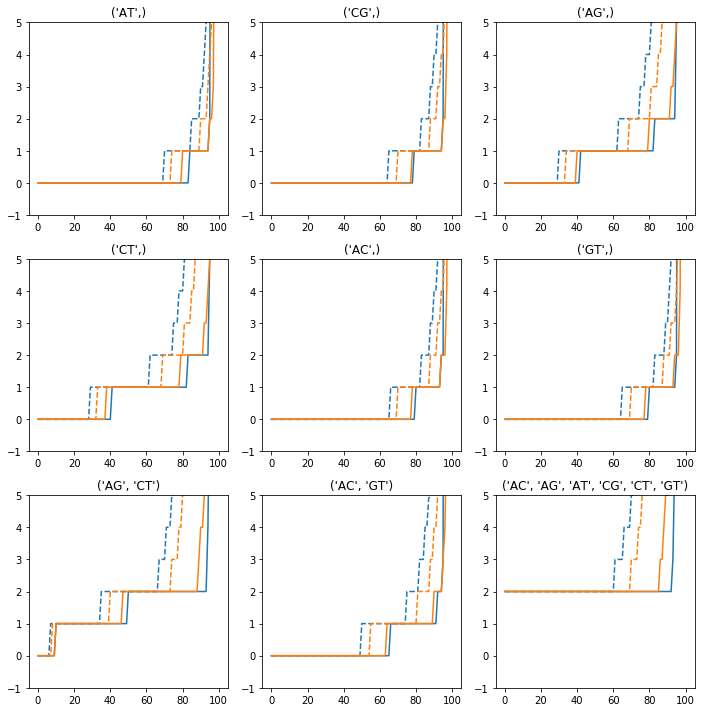

In [768]:
plt.figure(figsize=(10, 10))
for i, pairs in enumerate(of_interest):
    plt.subplot(3, 3, i+1)
    p = plt.plot(np.quantile([co['hets'][pairs] for co in crossover_recombs if 'hets' in co], np.arange(0, 1.01, 0.01)))
    plt.plot(np.quantile([co['another_hets'][pairs] for co in crossover_recombs if 'another_hets' in co], np.arange(0, 1.01, 0.01)),
            color=p[0].get_color(), linestyle='--')
    p = plt.plot(np.quantile([co['hets'][pairs] for co in gene_conversion_recombs if 'hets' in co], np.arange(0, 1.01, 0.01)))
    plt.plot(np.quantile([co['another_hets'][pairs] for co in gene_conversion_recombs if 'another_hets' in co], np.arange(0, 1.01, 0.01)),
            color=p[0].get_color(), linestyle='--')
    plt.title(pairs)
    plt.ylim([-1, 5])
    
plt.tight_layout()
plt.show()

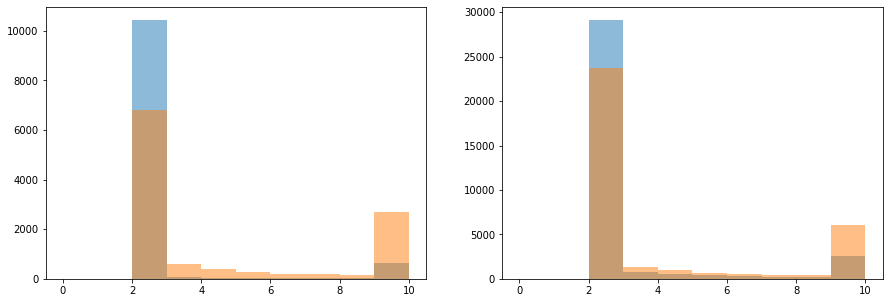

In [774]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.clip([co['hets'][of_interest[-1]] for co in crossover_recombs if 'hets' in co], None, 10), bins=np.arange(11), alpha=0.5)
plt.hist(np.clip([co['another_hets'][of_interest[-1]] for co in crossover_recombs if 'another_hets' in co], None, 10), bins=np.arange(11), alpha=0.5)

plt.subplot(1, 2, 2)
plt.hist(np.clip([co['hets'][of_interest[-1]] for co in gene_conversion_recombs if 'hets' in co], None, 10), bins=np.arange(11), alpha=0.5)
plt.hist(np.clip([co['another_hets'][of_interest[-1]] for co in gene_conversion_recombs if 'another_hets' in co], None, 10), bins=np.arange(11), alpha=0.5)

plt.show()


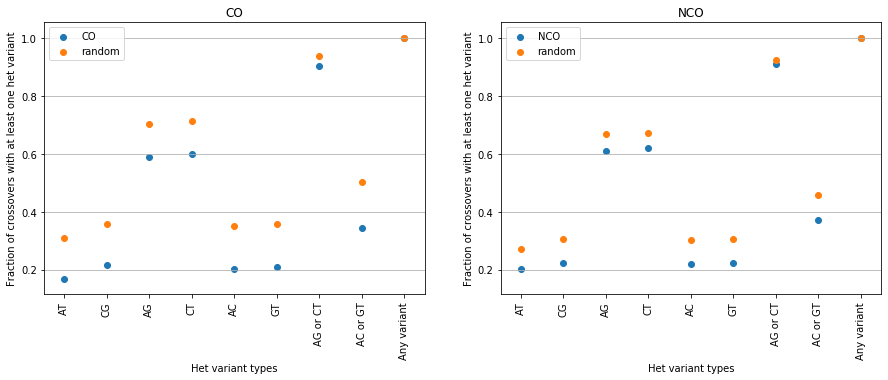

In [770]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
ps = np.array([len([co for co in crossover_recombs if 'hets' in co and co['hets'][pairs]>0]) for pairs in of_interest])
ns = np.array([len([co for co in crossover_recombs if 'hets' in co]) for pairs in of_interest])
plt.scatter(np.arange(len(of_interest)), ps/ns, label='CO')

ps = np.array([len([co for co in crossover_recombs if 'another_hets' in co and co['another_hets'][pairs]>0]) for pairs in of_interest])
ns = np.array([len([co for co in crossover_recombs if 'another_hets' in co]) for pairs in of_interest])
plt.scatter(np.arange(len(of_interest)), (ps/ns), label='random')

plt.xticks(range(len(of_interest)), [' or '.join(x) if len(x)<=2 else 'Any variant' for x in of_interest], rotation=90)
plt.ylabel('Fraction of crossovers with at least one het variant')
plt.xlabel('Het variant types')
plt.title('CO')
plt.legend()
plt.grid(True, 'major', 'y')

plt.subplot(1, 2, 2, sharey=ax)
ps = np.array([len([co for co in gene_conversion_recombs if 'hets' in co and co['hets'][pairs]>0]) for pairs in of_interest])
ns = np.array([len([co for co in gene_conversion_recombs if 'hets' in co]) for pairs in of_interest])
plt.scatter(np.arange(len(of_interest)), ps/ns, label='NCO')

ps = np.array([len([co for co in gene_conversion_recombs if 'another_hets' in co and co['another_hets'][pairs]>0]) for pairs in of_interest])
ns = np.array([len([co for co in gene_conversion_recombs if 'another_hets' in co]) for pairs in of_interest])
plt.scatter(np.arange(len(of_interest)), (ps/ns), label='random')

plt.xticks(range(len(of_interest)), [' or '.join(x) if len(x)<=2 else 'Any variant' for x in of_interest], rotation=90)
plt.ylabel('Fraction of crossovers with at least one het variant')
plt.xlabel('Het variant types')
plt.title('NCO')
plt.legend()
plt.grid(True, 'major', 'y')

plt.legend()
plt.show()

In [762]:
for pairs in of_interest:
    print(pairs, 
          len([co for co in crossover_recombs if 'hets' in co and co['hets'][pairs]>0])/len([co for co in crossover_recombs if 'hets' in co]),
          len([co for co in gene_conversion_recombs if 'hets' in co and co['hets'][pairs]>0])/len([co for co in gene_conversion_recombs if 'hets' in co]),
          stats.chi2_contingency([[len([co for co in crossover_recombs if 'hets' in co and co['hets'][pairs]>0]),
                              len([co for co in crossover_recombs if 'hets' in co])],
                              [len([co for co in gene_conversion_recombs if 'hets' in co and co['hets'][pairs]>0]),
                              len([co for co in gene_conversion_recombs if 'hets' in co])]
                              ])[1])

('AT',) 0.17043740573152338 0.2058754750073078 1.4246604539887191e-11
('CG',) 0.21675095377517523 0.22844197603040048 0.0413775579716323
('AG',) 0.5939135835329606 0.6198772288804443 0.01621784589868693
('CT',) 0.6028746340165025 0.6333528208126279 0.0053248531839953026
('AC',) 0.2048620353118623 0.22499269219526455 0.00034367469192392856
('GT',) 0.2096530920060332 0.2283835135925168 0.0009807103133251246
('AG', 'CT') 0.9075503504569249 0.9156971645717626 0.575461603427198
('AC', 'GT') 0.34673054742258896 0.37705349313066355 8.271969249356057e-05
('AC', 'AG', 'AT', 'CG', 'CT', 'GT') 1.0 1.0 1.0


In [581]:
crossover_recombs_mat = sum([sum([co['recombinations'] for co in v if co['is_mat']], []) for v in parent_to_crossovers.values()], [])
crossover_recombs_pat = sum([sum([co['recombinations'] for co in v if co['is_pat']], []) for v in parent_to_crossovers.values()], [])
gene_conversion_recombs_mat = sum([sum([co['recombinations'] for co in v if co['is_mat']], []) for v in parent_to_gcs.values()], [])
gene_conversion_recombs_pat = sum([sum([co['recombinations'] for co in v if co['is_pat']], []) for v in parent_to_gcs.values()], [])


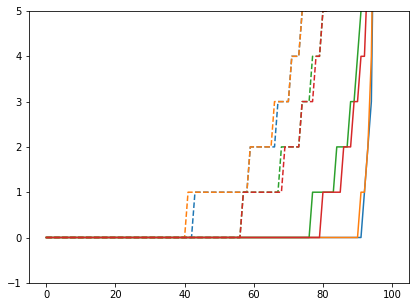

In [582]:
pairs = ('AG', 'CT')

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
p = plt.plot(np.quantile([co['hets'][pairs] for co in crossover_recombs_mat if 'hets' in co], np.arange(0, 1.01, 0.01)))
plt.plot(np.quantile([co['another_hets'][pairs] for co in crossover_recombs_mat if 'another_hets' in co], np.arange(0, 1.01, 0.01)),
        color=p[0].get_color(), linestyle='--')
p = plt.plot(np.quantile([co['hets'][pairs] for co in crossover_recombs_pat if 'hets' in co], np.arange(0, 1.01, 0.01)))
plt.plot(np.quantile([co['another_hets'][pairs] for co in crossover_recombs_pat if 'another_hets' in co], np.arange(0, 1.01, 0.01)),
        color=p[0].get_color(), linestyle='--')


p = plt.plot(np.quantile([co['hets'][pairs] for co in gene_conversion_recombs_mat if 'hets' in co], np.arange(0, 1.01, 0.01)))
plt.plot(np.quantile([co['another_hets'][pairs] for co in gene_conversion_recombs_mat if 'another_hets' in co], np.arange(0, 1.01, 0.01)),
            color=p[0].get_color(), linestyle='--')
p = plt.plot(np.quantile([co['hets'][pairs] for co in gene_conversion_recombs_pat if 'hets' in co], np.arange(0, 1.01, 0.01)))
plt.plot(np.quantile([co['another_hets'][pairs] for co in gene_conversion_recombs_pat if 'another_hets' in co], np.arange(0, 1.01, 0.01)),
            color=p[0].get_color(), linestyle='--')

plt.ylim([-1, 5])

plt.show()

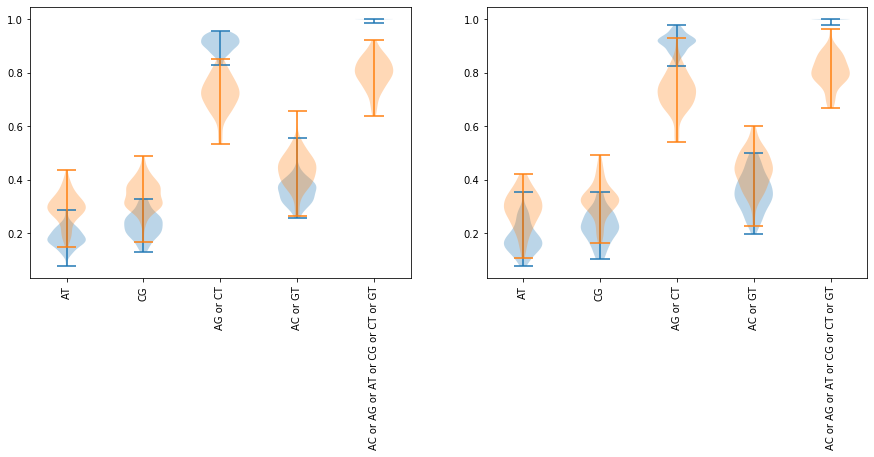

In [106]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.violinplot([[np.sum(counts_each_mom[mom][i, :])/np.sum(counts_each_mom[mom][-1, :]) for mom in counts_each_mom.keys()] for i in range(len(of_interest))])
plt.violinplot([[np.sum(counts_each_mom_base[mom][i, :])/np.sum(counts_each_mom_base[mom][-1, :]) for mom in counts_each_mom.keys() if np.sum(counts_each_mom[mom][-1, :])>0] for i in range(len(of_interest))])
plt.xticks(range(1, len(of_interest)+1), [' or '.join(x) for x in of_interest], rotation=90)

plt.subplot(1, 2, 2)
plt.violinplot([[np.sum(counts_each_dad[dad][i, :])/np.sum(counts_each_dad[dad][-1, :]) for dad in counts_each_dad.keys()] for i in range(len(of_interest))])
plt.violinplot([[np.sum(counts_each_dad_base[dad][i, :])/np.sum(counts_each_dad_base[dad][-1, :]) for dad in counts_each_dad.keys() if np.sum(counts_each_dad[dad][-1, :])>0] for i in range(len(of_interest))])
plt.xticks(range(1, len(of_interest)+1), [' or '.join(x) for x in of_interest], rotation=90)



plt.show()



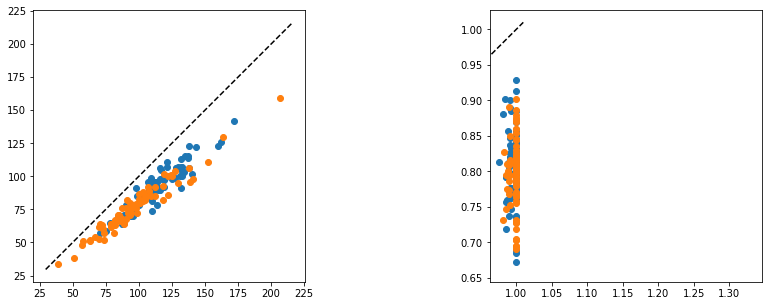

In [98]:
i = 2
moms = sorted(counts_each_mom.keys())
dads = sorted(counts_each_dad.keys())

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter([np.sum(counts_each_mom[mom][i, :]) for mom in moms],
            [np.sum(counts_each_mom_base[mom][i, :]) for mom in moms])
plt.scatter([np.sum(counts_each_dad[dad][i, :]) for dad in dads],
            [np.sum(counts_each_dad_base[dad][i, :]) for dad in dads])
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axis('square')

plt.subplot(1, 2, 2)
plt.scatter([np.sum(counts_each_mom[mom][i, :])/np.sum(counts_each_mom[mom][-1, :]) for mom in moms],
            [np.sum(counts_each_mom_base[mom][i, :])/np.sum(counts_each_mom_base[mom][-1, :]) for mom in moms])
plt.scatter([np.sum(counts_each_dad[dad][i, :])/np.sum(counts_each_dad[dad][-1, :]) for dad in dads],
            [np.sum(counts_each_dad_base[dad][i, :])/np.sum(counts_each_dad_base[dad][-1, :]) for dad in dads])
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axis('square')

plt.show()



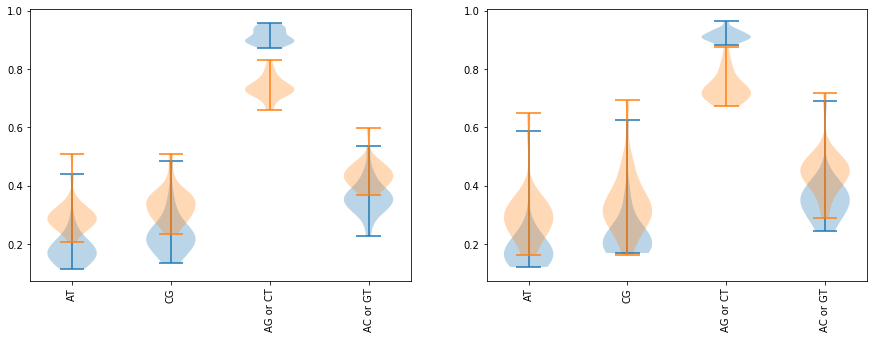

In [46]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.violinplot([counts_mom[i, :]/counts_mom[-1, :] for i in range(len(of_interest))])
plt.violinplot([counts_mom_base[i, :]/counts_mom_base[-1, :] for i in range(len(of_interest))])
plt.xticks(range(1, len(of_interest)+1), [' or '.join(x) for x in of_interest], rotation=90)

plt.subplot(1, 2, 2, sharey=ax)
plt.violinplot([counts_dad[i, :]/counts_dad[-1, :] for i in range(len(of_interest))])
plt.violinplot([counts_dad_base[i, :]/counts_dad_base[-1, :] for i in range(len(of_interest))])
plt.xticks(range(1, len(of_interest)+1), [' or '.join(x) for x in of_interest], rotation=90)

plt.show()



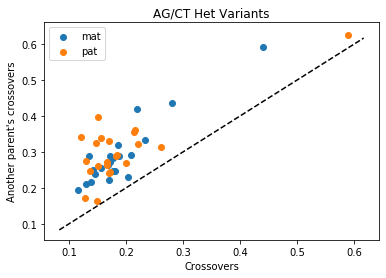

In [22]:
i = 2
plt.scatter(counts_mom[i, :]/counts_mom[-1, :], counts_mom_base[i, :]/counts_mom_base[-1, :], label='mat')
plt.scatter(counts_dad[i, :]/counts_dad[-1, :], counts_dad_base[i, :]/counts_dad_base[-1, :], label='pat')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.legend()
plt.xlabel('Crossovers')
plt.ylabel("Another parent's crossovers")
plt.title('AG/CT Het Variants')

plt.show()

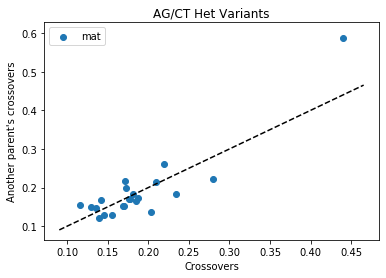

In [23]:
i = 2
plt.scatter(counts_mom[i, :]/counts_mom[-1, :], counts_dad[i, :]/counts_dad[-1, :], label='mat')
#plt.scatter(counts_dad[i, :]/counts_dad[-1, :], counts_dad_base[i, :]/counts_dad_base[-1, :], label='pat')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.legend()
plt.xlabel('Crossovers')
plt.ylabel("Another parent's crossovers")
plt.title('AG/CT Het Variants')

plt.show()

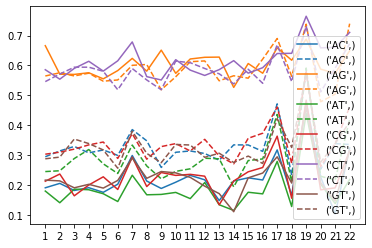

In [24]:
for i in range(len(of_interest)):
    p = plt.plot(counts_mom[i, :]/counts_mom[-1, :], label=of_interest[i])
    plt.plot(counts_mom_base[i, :]/counts_mom_base[-1, :], label=of_interest[i], color=p[0].get_color(), linestyle='--')
#plt.plot(counts_mom_base[i, :]/counts_mom_base[-1, :], label=of_interest[i])
#plt.plot(counts_dad[i, :]/counts_dad[-1, :])
plt.xticks(np.arange(len(chroms)), chroms)
plt.legend()
plt.show()

In [25]:
print(counts_mom)

[[105.  99.  82.  85.  75.  81. 109.  70.  57.  74.  69.  72.  32.  48.
   56.  47.  83.  36.  75.  48.  12.  37.]
 [365. 274. 256. 255. 236. 232. 227. 190. 196. 202. 184. 207. 135. 118.
  151. 124. 172. 134. 108. 124.  66.  74.]
 [ 99.  68.  84.  82.  73.  58.  85.  55.  51.  62.  46.  69.  29.  26.
   44.  37.  73.  28.  69.  43.  16.  25.]
 [117. 114.  74.  89.  97.  74. 107.  64.  73.  82.  70.  76.  29.  48.
   61.  56.  95.  34.  76.  39.  22.  36.]
 [321. 266. 265. 272. 247. 245. 247. 184. 166. 218. 173. 187. 126. 138.
  143. 128. 167. 139. 120. 139.  76.  81.]
 [119. 103.  86.  90.  81.  86. 106.  73.  74.  85.  67.  65.  37.  25.
   56.  52.  77.  45.  72.  44.  17.  36.]
 [548. 480. 449. 443. 425. 398. 364. 327. 301. 352. 296. 330. 215. 224.
  249. 216. 261. 217. 157. 211. 115. 114.]]


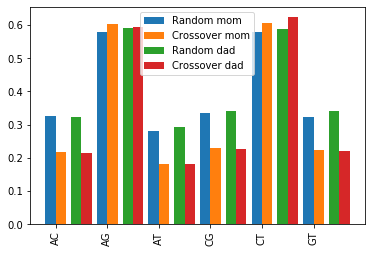

In [26]:
plt.xticks(range(len(of_interest)), [' or '.join(x) for x in of_interest], rotation=90)
plt.bar(np.arange(len(of_interest))-0.1, np.sum(counts_mom_base[:-1, :], axis=1)/np.sum(counts_mom_base[-1, :]), width=0.2, label='Random mom')
plt.bar(np.arange(len(of_interest))+0.1, np.sum(counts_mom[:-1, :], axis=1)/np.sum(counts_mom[-1, :]), width=0.2, label='Crossover mom')
plt.bar(np.arange(len(of_interest))+0.4, np.sum(counts_dad_base[:-1, :], axis=1)/np.sum(counts_dad_base[-1, :]), width=0.2, label='Random dad')
plt.bar(np.arange(len(of_interest))+0.6, np.sum(counts_dad[:-1, :], axis=1)/np.sum(counts_dad[-1, :]), width=0.2, label='Crossover dad')
plt.legend()
plt.show()

In [27]:
# AG or CT means A->G/T->C or G->A/C->T
# AC or GT means A->C/T->G or C->A/G->T
# AT means A->T or T->A
# CG means C->G or G->C
print(np.sum(counts_mom[of_interest.index(('AG', 'CT')), :])/np.sum(counts_mom[-1, :]))
print(np.sum(counts_dad[of_interest.index(('AG', 'CT')), :])/np.sum(counts_dad[-1, :]))

print(stats.chi2_contingency([[np.sum(counts_mom[of_interest.index(('AG', 'CT')), :]), np.sum(counts_mom[-1, :])-np.sum(counts_mom[of_interest.index(('AG', 'CT')), :])],
                              [np.sum(counts_mom_base[of_interest.index(('AG', 'CT')), :]), np.sum(counts_mom_base[-1, :])-np.sum(counts_mom_base[of_interest.index(('AG', 'CT')), :])]]))
print(stats.chi2_contingency([[np.sum(counts_dad[of_interest.index(('AG', 'CT')), :]), np.sum(counts_dad[-1, :])-np.sum(counts_dad[of_interest.index(('AG', 'CT')), :])],
                              [np.sum(counts_dad_base[of_interest.index(('AG', 'CT')), :]), np.sum(counts_dad_base[-1, :])-np.sum(counts_dad_base[of_interest.index(('AG', 'CT')), :])]]))


ValueError: ('AG', 'CT') is not in list